In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, cohen_kappa_score
from tabulate import tabulate
from imblearn.over_sampling import SMOTE

In [141]:
data = pd.read_json('../data/data.json')

In [142]:
# Asegúrate de que la columna 'FECHA' sea de tipo datetime
data['FECHA'] = pd.to_datetime(data['FECHA'])

# Crear una nueva columna con el día del año
data['DIA_DEL_ANO'] = data['FECHA'].dt.dayofyear

In [143]:
data['CA_G_1_1w'] = data['CA_G_1'].shift(1) # añadir el valor previo (1 semana) de CA_G_1 -> Clorofila

In [144]:
columns_to_change = ['BLOOM', 'BLOOM_1w', 'BLOOM_2w', 'BLOOM_PREDICT']
data[columns_to_change] = data[columns_to_change].replace(-1, 0)

data[columns_to_change] = data[columns_to_change].astype('category')

In [145]:
# Inicializar el LabelEncoder
le = LabelEncoder()

# Aplicar LabelEncoder a la columna STATION
data['STATION'] = le.fit_transform(data['STATION'])

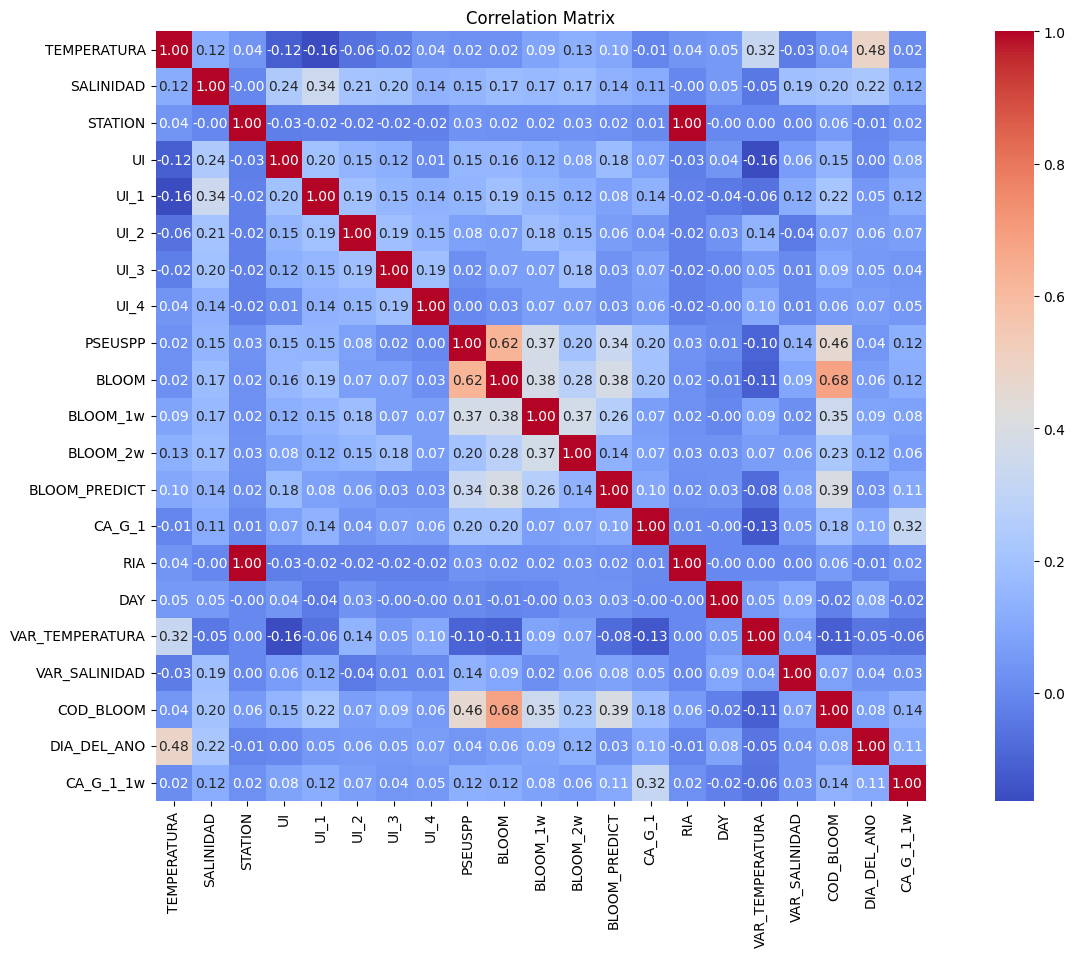

In [146]:
# Copia del DataFrame para evitar modificar el original
data_scaled = data.copy()

# Eliminar la columna FECHA
data_scaled = data_scaled.drop(columns=['FECHA'])

# Convertir todo a float64 antes de escalar
data_scaled = data_scaled.astype('float64')

# Aplicar MinMaxScaler a todas las columnas (escalado entre 0 y 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled.iloc[:, :] = scaler.fit_transform(data_scaled)

# Calcular la matriz de correlación
correlation_matrix = data_scaled.corr()

# Mostrar la matriz de correlación como un heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Preprocesamiento de los datos
data = data.dropna()
print(data.shape)

# Asegurarse de que la columna 'FECHA' esté en formato datetime
data['FECHA'] = pd.to_datetime(data['FECHA'])

# Dividir los datos en entrenamiento y prueba según la fecha
train_data = data[data['FECHA'] <= '2009-01-01']
test_data = data[data['FECHA'] > '2009-01-01']

# Definir las características y las etiquetas para entrenamiento y prueba
X_train = train_data.drop(columns=['FECHA', 'BLOOM_PREDICT'])
y_train = train_data['BLOOM_PREDICT']

X_test = test_data.drop(columns=['FECHA', 'BLOOM_PREDICT'])
y_test = test_data['BLOOM_PREDICT']

(1983, 22)


In [148]:
# Asegurarse de que las características estén en formato numérico (por ejemplo, usando get_dummies si tienes variables categóricas)
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Escalado de las características entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar SMOTE sobre el conjunto de entrenamiento
sm = SMOTE(random_state=42)
X_train_scaled, y_train = sm.fit_resample(X_train_scaled, y_train)


c:\Users\guille\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [149]:
# Definir los modelos a probar
kernels = ['rbf', 'poly']
degree_list = [2, 3, 4, 5]

# Función para calcular la especificidad
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Función para generar métricas y mostrar resultados
def get_metrics(model, X_train, X_test, y_train, y_test, kernel,average, degree=None):
    # Entrenar el modelo
    if kernel == 'poly' and degree is not None:
        model = SVC(kernel=kernel, degree=degree, class_weight='balanced')
    else:
        model = SVC(kernel=kernel, class_weight='balanced')
    
    model.fit(X_train, y_train)
    
    # Predicciones
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
 
    # Matrices de confusión
    tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_train_pred).ravel()
    tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_test_pred).ravel()
    
    # Cálculo de métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred, average=average)
    train_precision = precision_score(y_train, y_train_pred,average= average)
    train_sensitivity = recall_score(y_train, y_train_pred, average=average)
    train_specificity = specificity(y_train, y_train_pred)
    train_kappa = cohen_kappa_score(y_train, y_train_pred)
    
    # Cálculo de métricas para el conjunto de validación
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average=average)
    test_precision = precision_score(y_test, y_test_pred, average=average)
    test_sensitivity = recall_score(y_test, y_test_pred, average=average)
    test_specificity = specificity(y_test, y_test_pred)
    test_kappa = cohen_kappa_score(y_test, y_test_pred )
    
    # Devolver métricas
    return {
        'Kernel': kernel,
        'Degree': degree if kernel == 'poly' else None,
        'Train C+1': tp_train,  # Verdaderos Positivos en entrenamiento (Aciertos de bloom)
        'Train C-1': tn_train,  # Verdaderos Negativos en entrenamiento (Aciertos de no bloom)
        'Train M+1': fn_train,  # Falsos Negativos en entrenamiento (M+1)
        'Train M-1': fp_train,  # Falsos Positivos en entrenamiento (M-1)
        'Train F1': train_f1,
        'Train Precision': train_precision,
        'Train Specificity': train_specificity,
        'Train Sensitivity': train_sensitivity,
        'Train Kappa': train_kappa,
        'Test C+1': tp_test,  # Verdaderos Positivos en test (Aciertos de bloom)
        'Test C-1': tn_test,  # Verdaderos Negativos en test (Aciertos de no bloom)
        'Test M+1': fn_test,  # Falsos Negativos en test (M+1)
        'Test M-1': fp_test,  # Falsos Positivos en test (M-1)
        'Test F1': test_f1,
        'Test Precision': test_precision,
        'Test Specificity': test_specificity,
        'Test Sensitivity': test_sensitivity,
        'Test Kappa': test_kappa
    }

# Crear un DataFrame vacío para almacenar los resultados
results = []

# Ejecutar para diferentes kernels y grados
for kernel in kernels:
    if kernel == 'poly':
        for degree in degree_list:
            # Entrenamiento y prueba sin TimeSeriesSplit, ya que ya hemos dividido los datos
            metrics = get_metrics(SVC(), X_train_scaled, X_test_scaled, y_train, y_test, kernel, average='weighted',degree=degree)
            results.append(metrics)
    else:
        # Entrenamiento y prueba sin TimeSeriesSplit, ya que ya hemos dividido los datos
        metrics = get_metrics(SVC(), X_train_scaled, X_test_scaled, y_train, y_test, kernel, average='weighted')
        results.append(metrics)


In [150]:
print("Train:")
print(y_train.value_counts(normalize=True))
print("\nTest:")
print(y_test.value_counts(normalize=True))


Train:
BLOOM_PREDICT
0    0.5
1    0.5
Name: proportion, dtype: float64

Test:
BLOOM_PREDICT
0    0.86689
1    0.13311
Name: proportion, dtype: float64


In [151]:
# Convertir a DataFrame para mejor visualización
results_df = pd.DataFrame(results)

# Reestructurar el DataFrame a formato largo
long_results = pd.melt(results_df, 
                       id_vars=['Kernel', 'Degree'], 
                       value_vars=['Train C+1', 'Train C-1', 'Train M+1', 'Train M-1', 'Train F1', 'Train Precision', 'Train Specificity', 'Train Sensitivity', 
                                   'Train Kappa', 'Test C+1', 'Test C-1', 'Test M+1', 'Test M-1', 'Test F1', 'Test Precision', 
                                   'Test Specificity', 'Test Sensitivity', 'Test Kappa'], 
                       var_name='Metric', 
                       value_name='Score')

# Crear una nueva columna 'Data Type' para separar entrenamiento de validación
long_results['Data Type'] = long_results['Metric'].apply(lambda x: 'Train' if 'Train' in x else 'Test')

# Mostrar el DataFrame transformado
print(long_results)

# Guardar los resultados en un archivo CSV
long_results.to_csv('long_model_metrics_with_kappa_train_test_split.csv', index=False)

   Kernel  Degree      Metric       Score Data Type
0     rbf     NaN   Train C+1  741.000000     Train
1    poly     2.0   Train C+1  687.000000     Train
2    poly     3.0   Train C+1  847.000000     Train
3    poly     4.0   Train C+1  869.000000     Train
4    poly     5.0   Train C+1  869.000000     Train
..    ...     ...         ...         ...       ...
85    rbf     NaN  Test Kappa    0.329548      Test
86   poly     2.0  Test Kappa    0.333483      Test
87   poly     3.0  Test Kappa    0.307118      Test
88   poly     4.0  Test Kappa    0.289287      Test
89   poly     5.0  Test Kappa    0.236142      Test

[90 rows x 5 columns]


In [152]:
# Reemplazar NaN en la columna 'Degree' por 'N/A' o un valor representativo
long_results['Degree'] = long_results['Degree'].fillna("N/A")

# Filtrar los resultados para entrenamiento y test (anteriormente validación)
train_results = long_results[long_results['Data Type'] == 'Train']
test_results = long_results[long_results['Data Type'] == 'Test']  # Cambiar 'Val' por 'Test'

# Pivotar la tabla para tener las métricas en columnas separadas
train_pivot = train_results.pivot_table(index=['Kernel', 'Degree'], columns='Metric', values='Score')
test_pivot = test_results.pivot_table(index=['Kernel', 'Degree'], columns='Metric', values='Score') 

# Convertir las tablas pivotadas en formato tabulate
train_table = tabulate(train_pivot, headers='keys', tablefmt='grid', showindex=True)
test_table = tabulate(test_pivot, headers='keys', tablefmt='grid', showindex=True)  

# Mostrar las tablas
print("Tabla de Entrenamiento:")
print(train_table)

print("\nTabla de Test:")
print(test_table)  

Tabla de Entrenamiento:
+----------------+-------------+-------------+------------+---------------+-------------+-------------+-------------------+---------------------+---------------------+
|                |   Train C+1 |   Train C-1 |   Train F1 |   Train Kappa |   Train M+1 |   Train M-1 |   Train Precision |   Train Sensitivity |   Train Specificity |
+================+=============+=============+============+===============+=============+=============+===================+=====================+=====================+
| ('poly', 2.0)  |         687 |         770 |   0.798376 |      0.597588 |         225 |         142 |          0.801289 |            0.798794 |            0.844298 |
+----------------+-------------+-------------+------------+---------------+-------------+-------------+-------------------+---------------------+---------------------+
| ('poly', 3.0)  |         847 |         782 |   0.892956 |      0.786184 |          65 |         130 |          0.895099 |            0